# all converted to MongoDB

In [2]:
from pymongo import MongoClient
from collections import Counter

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  # Replace 'your_database' with your actual database name
collection = db['reports']  # Replace 'your_collection' with your actual collection name

# Number of Entries per Year

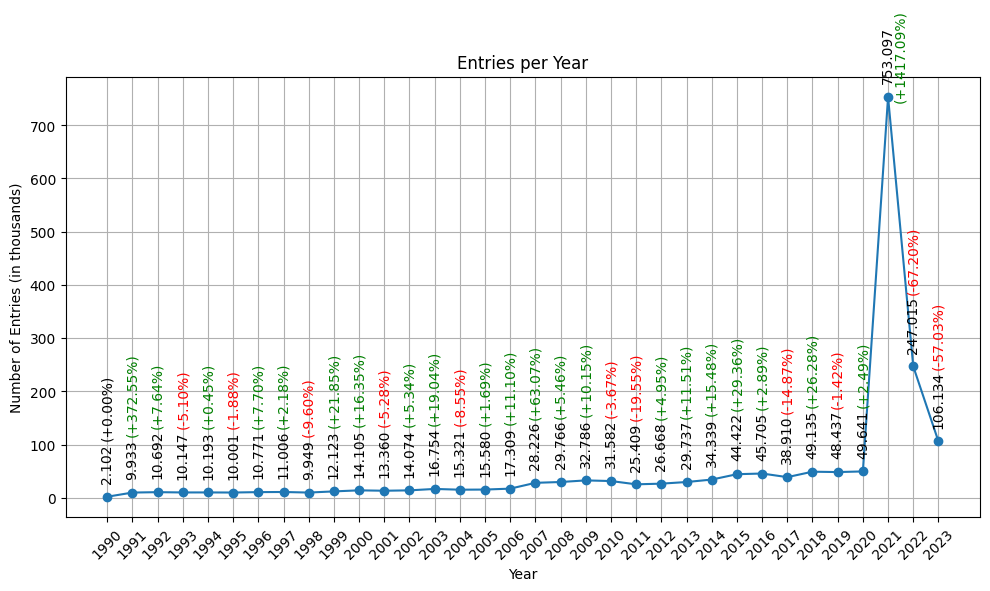

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Query the database for documents
documents_cursor = collection.find({}, {"RECVDATE": 1})

# Process documents to count entries per year
for document in documents_cursor:
    recv_date = document.get('RECVDATE')
    if recv_date:
        year = recv_date.year
        entries_per_year[year] = entries_per_year.get(year, 0) + 1

# Convert the dictionary to lists for plotting
years = list(entries_per_year.keys())
counts = list(entries_per_year.values())

# Calculate percentage change
pct_change = [0]  # Start with 0 for the first year
for i in range(1, len(counts)):
    change = ((counts[i] - counts[i-1]) / counts[i-1]) * 100
    pct_change.append(change)

# Plotting the data as a line graph
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', label='Number of Entries')
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('Entries per Year')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value and percentage change
for year, count, pct_change in zip(years, counts, pct_change):
    formatted_value = format_with_dot(count)

    # Annotate with the count value in default color, larger font size, and rotated 90 degrees
    plt.annotate(formatted_value, (year, count + 5000), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90)

    color = 'black'
    if pct_change != 0:
        color = 'green' if pct_change > 0 else 'red'
        
    # Determine the offset based on the count
    if count < 10000:
        offset = 85500
        xoffset = 0 
    elif count < 100000:
        offset = 100000
        xoffset = 0
    elif count < 250000:
        offset = 115000
        xoffset = 0
    else:
        offset = -30000  # Adjust the offset to the right
        xoffset = 0.5
        
    # Annotate with the percentage change in colored text, larger font size, and rotated 90 degrees
    plt.annotate(f"({pct_change:+.2f}%)", (year + xoffset, count + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color=color)



plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/Entries_per_Year_dotted.png')
plt.show()

# Number of COVID19 Vaccine Entries per Year

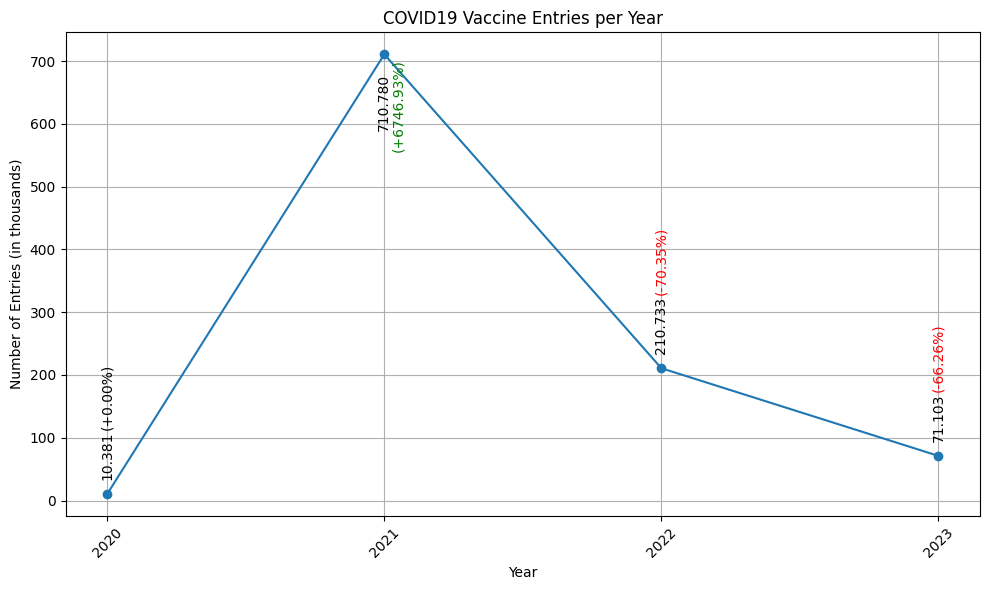

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# Custom formatter function
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Query the database for documents within the range of years 2020-2023 and containing "COVID" in VAX_TYPE
query = {
    "vax_data.VAX_TYPE": {"$regex": "COVID", "$options": "i"},
    "RECVDATE": {"$gte": datetime(2020, 1, 1), "$lte": datetime(2023, 12, 31)}
}
documents_cursor = collection.find(query, {"RECVDATE": 1})

# Process documents to count entries per year
for document in documents_cursor:
    recv_date = document.get('RECVDATE')
    if recv_date:
        year = recv_date.year
        entries_per_year[year] = entries_per_year.get(year, 0) + 1

# Convert the dictionary to lists for plotting
years = list(entries_per_year.keys())
counts = list(entries_per_year.values())

# Calculate percentage change
pct_change = [0]  # Start with 0 for the first year
for i in range(1, len(counts)):
    change = ((counts[i] - counts[i-1]) / counts[i-1]) * 100
    pct_change.append(change)

# Plotting the data as a line graph
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', label='Number of Entries')
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('COVID19 Vaccine Entries per Year')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value and percentage change
for year, count, pct_change in zip(years, counts, pct_change):
    formatted_value = format_with_dot(count)
    
    offset = 5000
    # Annotate with the count value
    if year == 2021: 
        offset = -140000

    plt.annotate(formatted_value, (year, count + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90)

    color = 'black'
    if pct_change != 0:
        color = 'green' if pct_change > 0 else 'red'
        
    # Determine the offset based on the count
    if count < 100000:
        offset = 85000
        xoffset= 0 
    elif count >= 100000 and count < 250000:
        offset = 100000
        xoffset= 0
    else:
        offset = -172500
        xoffset= 0.05
        
    # Annotate with the percentage change in colored text, larger font size, and rotated 90 degrees
    plt.annotate(f"({pct_change:+.2f}%)", (year + xoffset, count + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90, color=color)

plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/COVID19_Entries_per_Year_dotted.png')
plt.show()
